In [5]:
### Library
import numpy as np
import pandas as pd

import timeit
import time
import os
from datetime import datetime
from pathlib import Path
import ipynbname

import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec
import seaborn as sns
# import plotly.express as px
import ptitprince as pt
# import statsmodels
from sklearn.feature_selection import f_regression
from sklearn.inspection import PartialDependenceDisplay


In [2]:
### Make result directory
script_dir = os.path.abspath('')
current_file = os.path.basename(globals()['__vsc_ipynb_file__']).replace('.ipynb', '')
dt_string = datetime.now().strftime("%y%m%d_%H%M%S")
result_dir = os.path.join(script_dir, 'Results', current_file, dt_string)
Path(result_dir).mkdir(parents=True, exist_ok=True)

In [9]:
### Get data
input_variables = ["$x_{1}$: External wall thickness", "$x_{2}$: Internal wall thickness", "$x_{3}$: Thermal conductivity of Wall bricks", "$x_{4}$: Lightweight roof thickness", 
                   "$x_{5}$: Thermal resistance of Roof infill-blocks", "$x_{6}$: Thermal transmittance rate of Front doors frame", "$x_{7}$: Thermal transmittance rate of Window frame",
                   "$x_{8}$: Indoor air temperature", "$x_{9}$: Outdoor temperature change"]
output_variables = ["$y_{1}$: Total energy requirement", "$y_{11}$: Energy requirement of WC2", "$y_{5}$: Energy requirement of Study room", "$y_{6}$: Energy requirement of Entertainment room", 
                    "$y_{8}$: Energy requirement of Bedroom 2", "$y_{9}$: Energy requirement of Bedroom 3", "$y_{4}$: Energy requirement of Kitchen", "$y_{10}$: Energy requirement of WC1", 
                    "$y_{2}$: Energy requirement of Lobby", "$y_{3}$: Energy requirement of Living room", "$y_{7}$: Energy requirement of Bedroom 1"]

input_units = ["(mm)", "(mm)", "(W/mK)", "(mm)", "(m$^{2}$K/W)", "(W/m$^{2}$/K)", "(W/m$^{2}$/K)", "(°C)", "(°C)"]
output_units = ["(kWh)", "(kWh)", "(kWh)", "(kWh)", "(kWh)", "(kWh)", "(kWh)", "(kWh)", "(kWh)", "(kWh)", "(kWh)"]

data_df = pd.read_excel('./Data/dataset_simulation_building.xlsx', names=input_variables + output_variables)

output_variables = sorted(output_variables, key=lambda x: int(x.split("_")[1].split("}")[0].replace("{", "")))
data_df = data_df[input_variables + output_variables]

data_df.head()

output_variables_short = [var.split(":")[0].strip() for var in output_variables]
input_variables_short = [var.split(":")[0].strip() for var in input_variables]
rename_dict = dict(zip(input_variables + output_variables, input_variables_short + output_variables_short))
data_df_short = data_df.rename(columns=rename_dict)
data_df_short.head()

,$x_{1}$,$x_{2}$,$x_{3}$,$x_{4}$,$x_{5}$,$x_{6}$,$x_{7}$,$x_{8}$,$x_{9}$,$y_{1}$,$y_{2}$,$y_{3}$,$y_{4}$,$y_{5}$,$y_{6}$,$y_{7}$,$y_{8}$,$y_{9}$,$y_{10}$,$y_{11}$
M000,380,240,0.2,500,2.2,2.6,2.6,27.0,3.0,21258.73,1436.49,3532.37,3993.94,2075.23,4182.90,1583.47,1803.13,1793.23,472.73,385.22
M001,340,240,0.4,380,1.0,2.0,2.6,22.5,2.0,35777.61,2151.54,5338.95,6290.27,3814.10,7550.64,2635.11,3289.73,3309.99,740.88,656.40
M002,280,220,1.2,480,1.8,2.8,2.2,22.0,1.5,40265.74,2286.31,5754.52,6891.06,4256.44,8769.64,3057.76,3811.66,3825.65,854.57,758.14
M003,220,240,1.0,300,0.6,1.8,1.4,23.0,6.0,62957.19,3330.95,8442.04,10319.83,7096.79,14304.48,4425.83,6266.99,6382.39,1197.26,1190.63
M004,360,260,0.4,420,0.2,1.8,2.8,23.0,3.5,43724.45,2426.61,5961.04,7082.79,5334.65,9749.46,2917.05,4199.52,4470.02,797.63,785.68


In [10]:
### Statistical features
print('----- Data summary -----')
print(data_df.describe())
new_df = pd.DataFrame(round(data_df.describe(), 2))
new_df.to_csv(os.path.join(result_dir, 'Statistical_Features.csv'), index=True)

----- Data summary -----
       $x_{1}$: External wall thickness  $x_{2}$: Internal wall thickness  \
count                       1000.000000                       1000.000000   
mean                         299.780000                        199.280000   
std                           62.432759                         62.745666   
min                          200.000000                        100.000000   
25%                          240.000000                        140.000000   
50%                          300.000000                        200.000000   
75%                          360.000000                        260.000000   
max                          400.000000                        300.000000   

       $x_{3}$: Thermal conductivity of Wall bricks  \
count                                   1000.000000   
mean                                       0.690600   
std                                        0.320147   
min                                        0.200000   
25%   

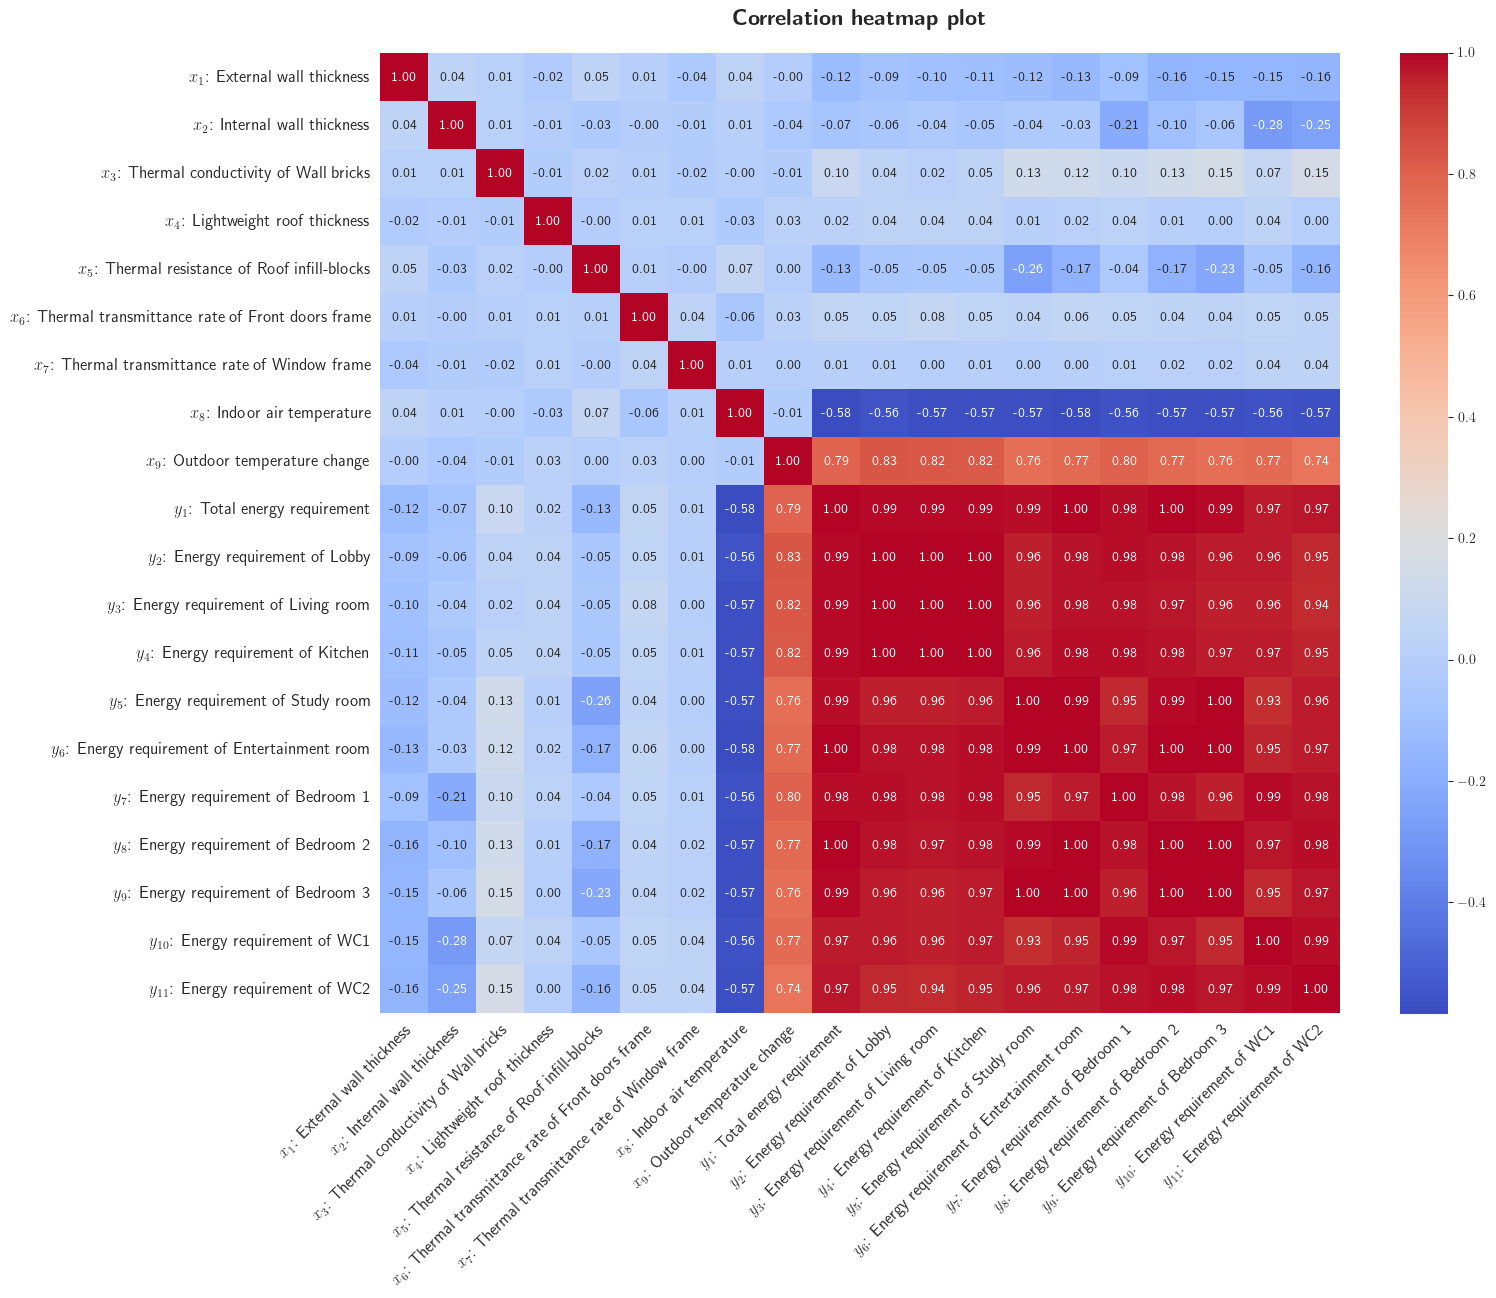

In [12]:
### Correlation matrix
plt.rcParams['text.usetex'] = True
sns.set_style("darkgrid")
corr_matrix = data_df.corr()
# new_df = pd.DataFrame(corr_matrix_full)
# new_df.to_csv(os.path.join(result_dir, 'Correlation_Matrix.csv'), header=None, index=False)
plt.figure(r'Correlation Heatmap', figsize=(16, 13))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title(r'\textbf{Correlation heatmap plot}', pad=20, fontsize=16)
# plt.xlabel(r'Variables', fontsize=10)
# plt.ylabel(r'Variables', fontsize=10)
plt.xticks(rotation=45, rotation_mode='anchor', horizontalalignment='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(result_dir, 'Correlation_Heatmap.png'), dpi=400)
plt.show()

c:\Users\tqkim\.conda\envs\KANs\lib\site-packages\seaborn\categorical.py:98: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isscalar(data[0]):
c:\Users\tqkim\.conda\envs\KANs\lib\site-packages\seaborn\categorical.py:98: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isscalar(data[0]):
c:\Users\tqkim\.conda\envs\KANs\lib\site-packages\seaborn\categorical.py:98: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isscalar(da

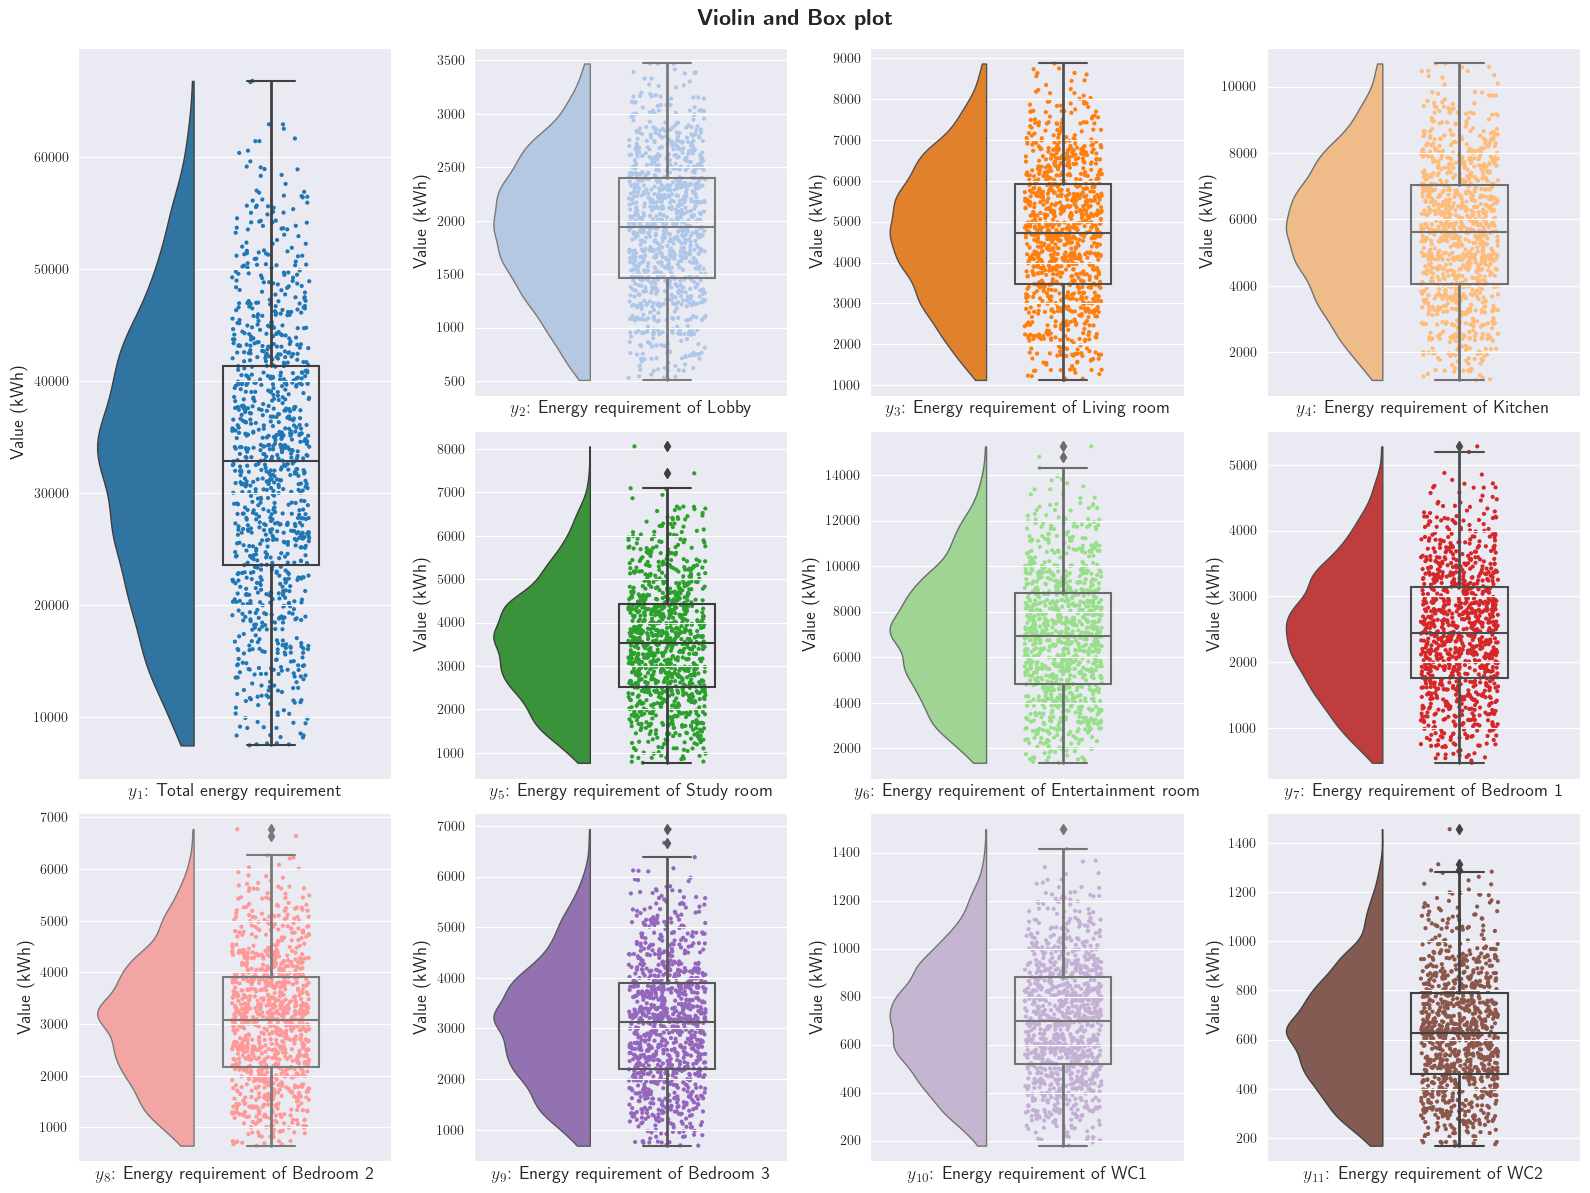

In [14]:
### Violin and Box plot
plt.rcParams['text.usetex'] = True
sns.set_style("darkgrid")
[nrows, ncols] = [3, 4]
fig = plt.figure(figsize=(16, 12), constrained_layout=True)
gs = fig.add_gridspec(nrows, ncols)

fig.suptitle(r'\textbf{Violin and Box plot}', y=0.99, fontsize=16)
pal = sns.color_palette("tab20", n_colors=len(output_variables))
for i in range(len(output_variables)):
    var = output_variables[i]
    idx = [(i//ncols) % nrows, i % ncols]
    if idx == [0,0]:
        ax1 = fig.add_subplot(gs[0:2, 0])
    elif idx == [1,3]:
        ax1 = fig.add_subplot(gs[2, 0])
    elif idx[0] != 0:
        ax1 = fig.add_subplot(gs[idx[0],idx[1]+1])
    else: 
        ax1 = fig.add_subplot(gs[idx[0],idx[1]])
    # ax1 = pt.half_violinplot(ax=ax1, data=data_df[var], palette=pal, bw=0.2, cut=0, scale='area', width=0.6, inner=None, orient='v')
    # ax1 = sns.stripplot(ax=ax1, data=data_df[var], palette=pal, edgecolor='white', size=3, jitter=1, zorder=0, orient='v')
    # ax1 = sns.boxplot(ax=ax1, data=data_df[var], color="black", width=0.15, zorder=10, showcaps=True, boxprops = {'facecolor':'none', "zorder":10},
    #                   showfliers=True, whiskerprops ={'linewidth':2, "zorder":10}, saturation=1, orient = 'v')
    ax1 = pt.RainCloud(ax=ax1, data=data_df[var], palette=[pal[i]], bw=0.2, width_viol=0.5, width_box=0.25, orient='v')
    ax1.set_xlabel(rf'{var}', fontsize=13)
    ax1.set_ylabel(rf'Value {output_units[i]}', fontsize=13)
    ax1.tick_params(axis='y', labelsize=10)
    ax1.set_xticks([])

plt.tight_layout(rect=(0, 0, 1, 1))
plt.subplots_adjust(hspace=0.1)
plt.savefig(os.path.join(result_dir, 'Violin_and_Box_plot.png'), dpi=400)
plt.show()

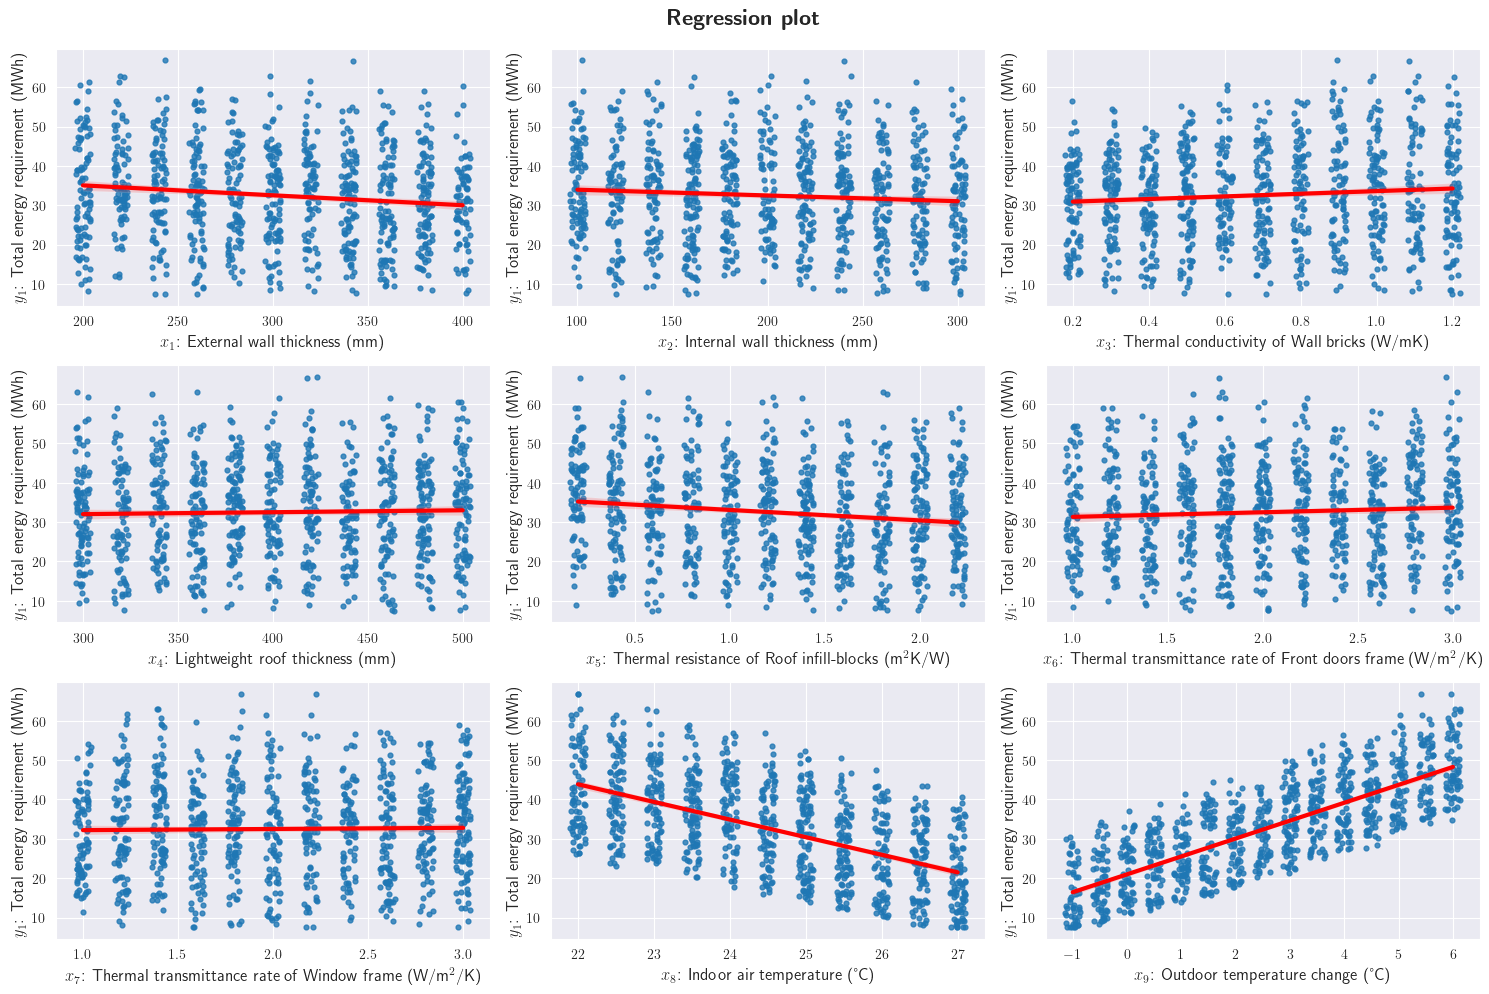

In [15]:
### Regression plot of input variables and one output variable
plt.rcParams['text.usetex'] = True
sns.set_style("darkgrid")
[nrows, ncols] = [3, 3]
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
fig.suptitle(r'\textbf{Regression plot}', y=0.99, fontsize=16)
# pal = sns.color_palette("tab20", n_colors=len(output_variables))
for i in range(len(input_variables)):
    var = input_variables[i]
    ax1 = axes[(i//ncols) % nrows, i % ncols]
    ax1 = sns.regplot(ax=ax1, x=data_df[var], y=data_df[output_variables[0]]/1000, ci=90, x_jitter=0.02*(np.max(data_df[var])-np.min(data_df[var])), robust=True, marker='o', 
                      scatter_kws=dict(alpha=0.8, s=12), line_kws=dict(color='red', linewidth=3))
    ax1.set_xlabel(ax1.get_xlabel() + ' ' + input_units[i], fontsize=12)
    ax1.set_ylabel(ax1.get_ylabel() + ' (MWh)', fontsize=12)
    ax1.tick_params(axis='x', labelsize=10)
    ax1.tick_params(axis='y', labelsize=10)
               
plt.tight_layout(rect=(0, 0, 1, 1))
plt.savefig(os.path.join(result_dir, 'Regression_Plot.png'), dpi=400)
plt.show()

<Figure size 1000x1200 with 0 Axes>

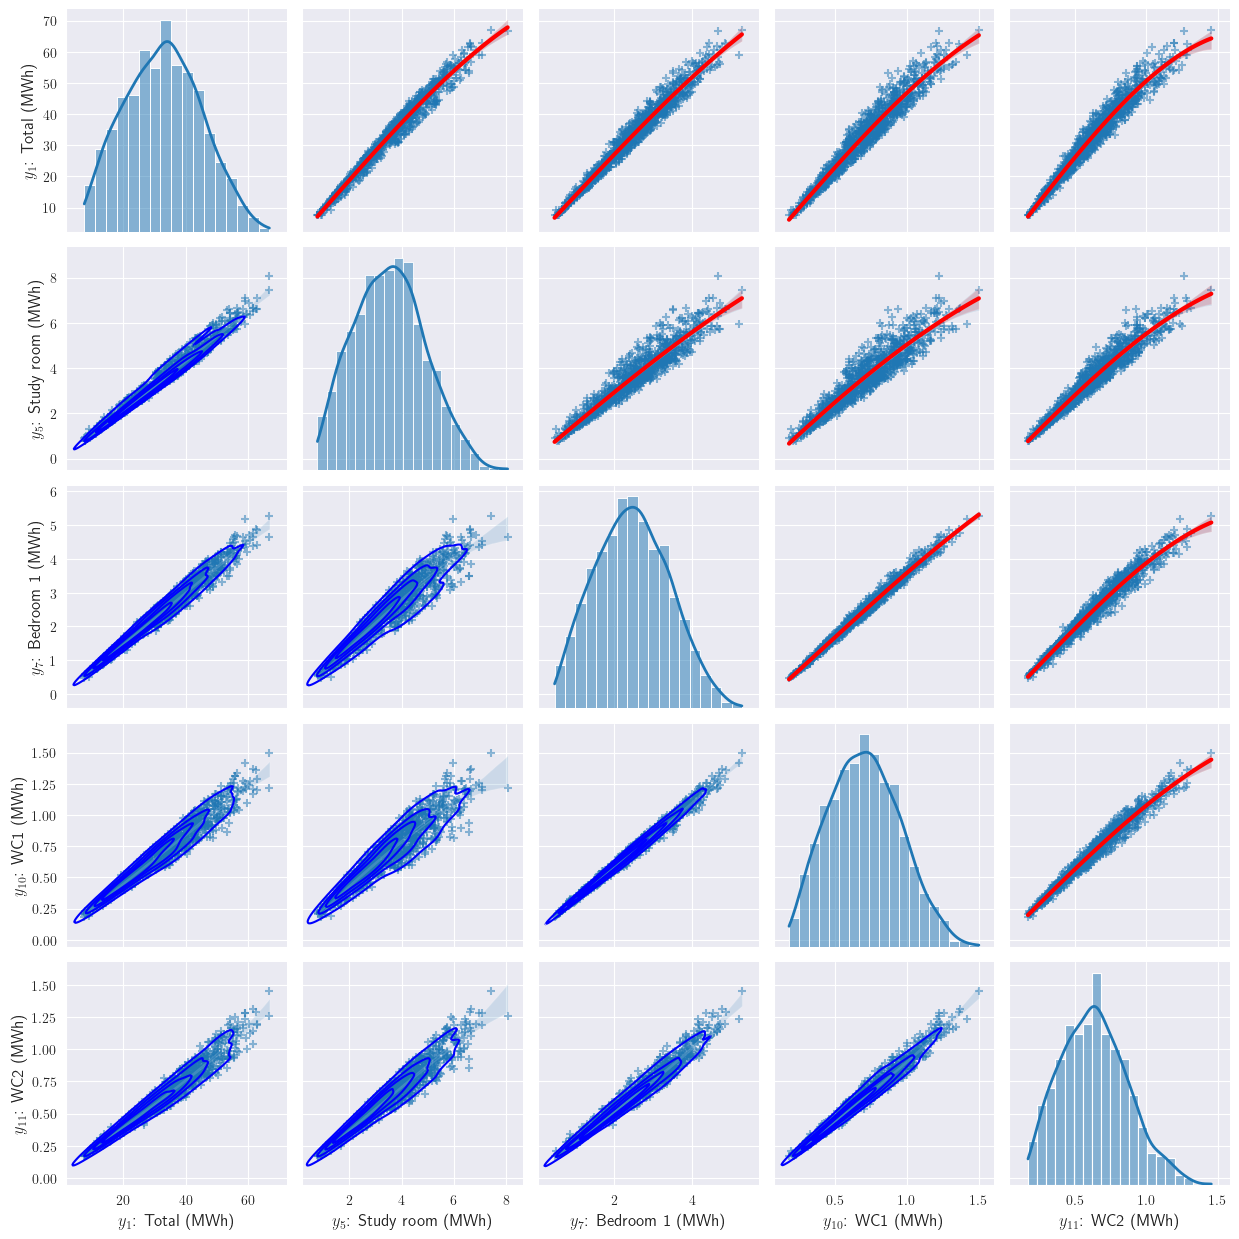

In [21]:
### Parir plot of Output variables
plt.rcParams['text.usetex'] = True
sns.set_style("darkgrid")
plt.figure(figsize=(10, 12), constrained_layout=True)
plt.suptitle(r'\textbf{Pair plot}', y=0.99, fontsize=16)

output_temp_variables = ["$y_{1}$: Total", "$y_{2}$: Lobby", "$y_{3}$: Living room", "$y_{4}$: Kitchen", "$y_{5}$: Study room", "$y_{6}$: Entertainment room",
                         "$y_{7}$: Bedroom 1", "$y_{8}$: Bedroom 2", "$y_{9}$: Bedroom 3",  "$y_{10}$: WC1",  "$y_{11}$: WC2"]

rename_dict = dict(zip(input_variables + output_variables, input_variables + output_temp_variables))
data_df_temp = data_df.rename(columns=rename_dict)

fig = sns.pairplot(data_df_temp[[output_temp_variables[i] for i in [0, 4, 6, 9, 10]]]/1000,
                   kind='reg', plot_kws=dict(order=3, marker='+', scatter_kws=dict(alpha=0.5), line_kws=dict(linestyle='none')),
                   diag_kind='none')
fig.map_upper(sns.regplot, order=3, scatter=False, line_kws=dict(color='red', linewidth=3))
fig.map_lower(sns.kdeplot, levels=5, color="blue", thresh=0.1)
fig.map_diag(sns.histplot, kde=True, line_kws=dict(color='red', linewidth=2))

for ax in fig.axes.flatten():
    xlim = ax.get_xlim()
    if ax.get_xlabel() == output_temp_variables[-1]:
        ax.set_xlim(xlim[0] - 0.18*(xlim[1]-xlim[0]), xlim[1] + 0.18*(xlim[1]-xlim[0]))
    else:
        ax.set_xlim(xlim[0] + 0.015*(xlim[1]-xlim[0]), xlim[1] - 0.015*(xlim[1]-xlim[0]))
    xlabel = ax.get_xlabel() + ' (MWh)' if ax.get_xlabel() else ax.get_xlabel()
    ylabel = ax.get_ylabel() + ' (MWh)' if ax.get_ylabel() else ax.get_ylabel()
    ax.set_xlabel(xlabel, fontsize=12) 
    ax.set_ylabel(ylabel, fontsize=12)  
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

plt.tight_layout(rect=(0, 0, 1, 1))
plt.savefig(os.path.join(result_dir, 'Pair_Plot.png'), dpi=400)
plt.show()

c:\Users\tqkim\.conda\envs\KANs\lib\site-packages\seaborn\_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\tqkim\.conda\envs\KANs\lib\site-packages\seaborn\_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\tqkim\.conda\envs\KANs\lib\site-packages\seaborn\_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\tqkim\.conda\envs\KANs\lib\site-packages\se

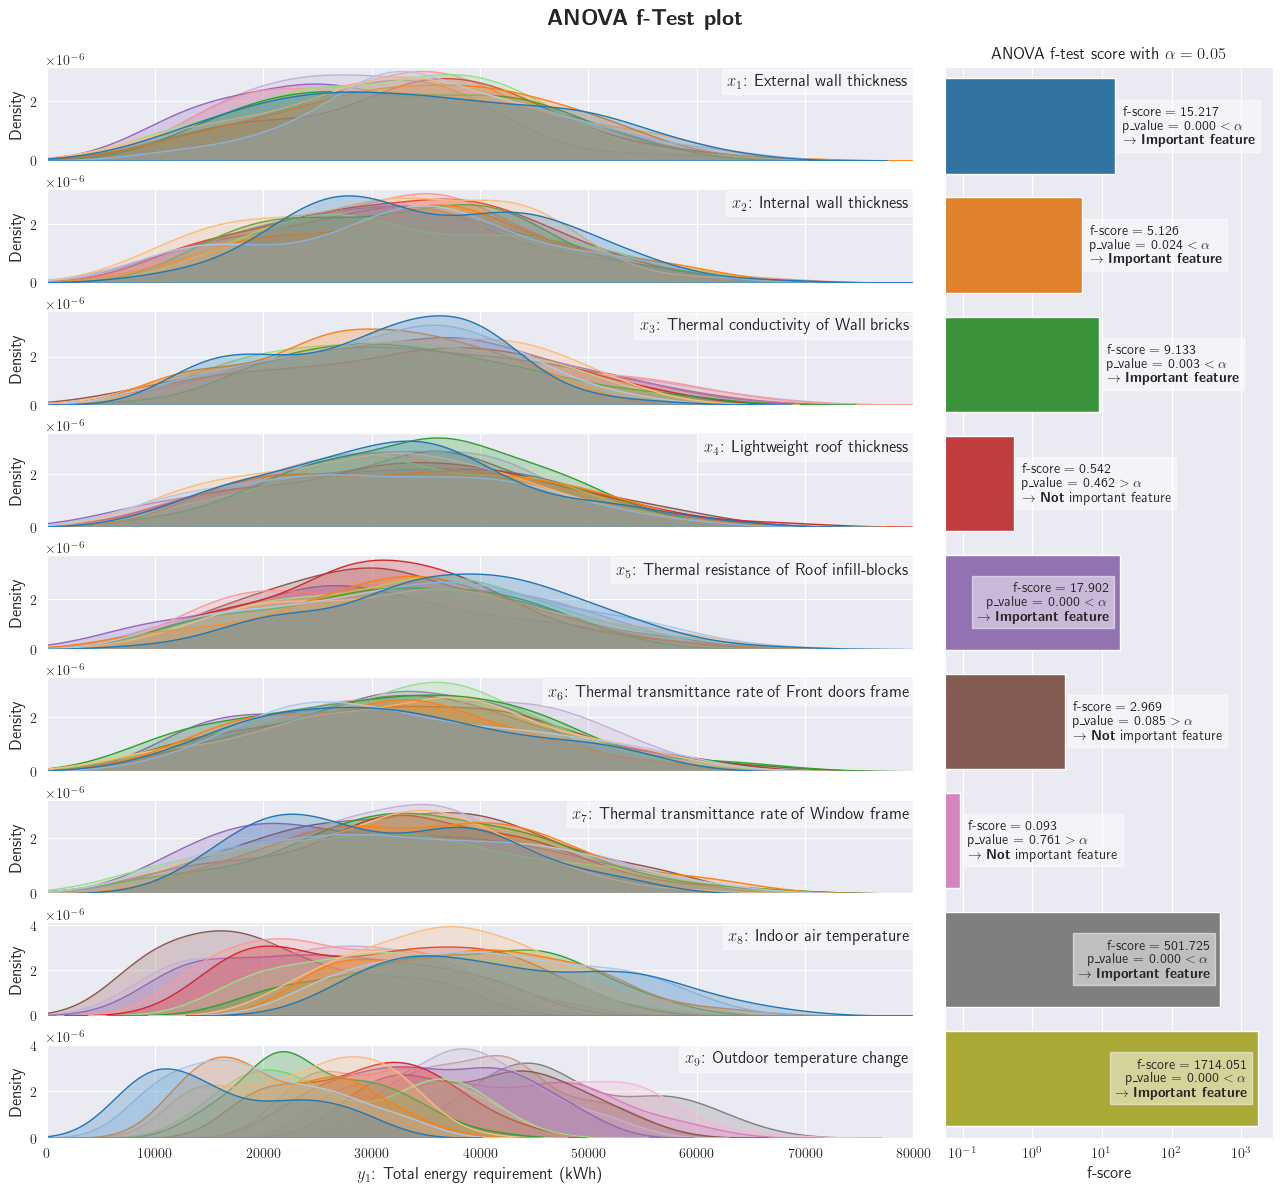

In [22]:
### ANOVA f-Static Plot
f_scores, p_values = f_regression(data_df[input_variables], data_df[output_variables[0]])
# print("\nFeature Importances:")
# print(f_scores)
# print(np.around(p_values, 4))
# print(np.array(np.where(p_values <= 0.05))+1)

plt.rcParams['text.usetex'] = True
sns.set_style("darkgrid")
[nrows, ncols] = [9, 7]
fig = plt.figure(figsize=(13, 12), constrained_layout=True)
gs = fig.add_gridspec(nrows, ncols)

fig.suptitle(r'\textbf{ANOVA f-Test plot}', y=0.99, fontsize=16)
pal = sns.color_palette("tab20", n_colors=len(input_variables))
for i in range(len(input_variables)):
    var = input_variables[i]
    ax1 = fig.add_subplot(gs[i, 0:5])
    ax1 = sns.kdeplot(ax=ax1, x=data_df[output_variables[0]], hue=data_df[var], fill=True, palette="tab20")
    ax1.set_xlabel('')
    ax1.set_ylabel(ax1.get_ylabel(), fontsize=12)
    ax1.tick_params(axis='x', labelsize=10)
    ax1.tick_params(axis='y', labelsize=10)
    ax1.set_xlim(0, 80000)
    if i == len(input_variables)-1:
        ax1.set_xlabel(rf'{output_variables[0]}' + ' (kWh)', fontsize=12)
    else:
        ax1.set_xticklabels([])
        
    ax1.legend_.remove()
    ax1.text(0.995, 0.92, var, transform=ax1.transAxes, fontsize=12, 
             ha='right', va='top', bbox=dict(facecolor='white', alpha=0.5))

ax1 = fig.add_subplot(gs[:, 5:])
ax1 = sns.barplot(ax=ax1, x=f_scores, y=input_variables)
ax1.set_title(r'ANOVA f-test score with $\alpha = 0.05$', fontsize=12)
ax1.set_xlabel('f-score', fontsize=12)
ax1.tick_params(axis='x', labelsize=10)
ax1.set_xscale('log')
ax1.set_yticks([])

for i, (x, y) in enumerate(zip(f_scores, input_variables)):
    ax1.text(x*0.7 if x >= 17 else x*1.3, i,
             rf'f-score = {x:.3f}' + '\n'
             rf' p_value = {p_values[i]:.3f} $< \alpha$' + '\n' 
             r'$\rightarrow$ \textbf{Important feature}' if p_values[i] < 0.05 else
             rf'f-score = {x:.3f}' + '\n'
             rf'p_value = {p_values[i]:.3f} $> \alpha$' + '\n'
             r'$\rightarrow$ \textbf{Not} important feature' , fontsize=10,
             ha='right' if x >= 17 else 'left', va='center', bbox=dict(facecolor='white', alpha=0.5))
    
plt.tight_layout(rect=(0, 0, 1, 1))
plt.subplots_adjust(hspace=0.3)
plt.savefig(os.path.join(result_dir, 'ANOVA_f_test_plot.png'), dpi=400)
plt.show()